# This notebook plots and models the COVID-19 infection in the Republic of Ireland

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Get the data](#0)<br>
2. [Plot Ireland data](#1)<br>
3. [Model the number of cases by Country](#2)<br>

</div>
<hr>

### Import libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib as mpl
#matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
#%matplotlib inline
mpl.style.use('ggplot')
import os
import time
from selenium import webdriver
import folium
from folium.features import DivIcon

# 1. Get the data<a id="0"></a>
Source: [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv)

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url) #, error_bad_lines=False) # https://stackoverflow.com/a/43832955)
df.shape # gives number of rows and columns

(253, 71)

In [5]:
df.head() # displays first 5 rows

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


**Pick the country for analysis and display case numbers for the last five days**

In [6]:
country = 'Ireland'
condition = df['Country/Region'] == country # filter df by country
df_ire=df[condition].loc[:, '1/22/20':].transpose() # apply filter, slice the dataframe for only date data, and transpose
df_ire.reset_index(inplace=True) # reset the index
df_ire.columns=['Date', 'Cases'] # rename the columns
df_ire['Date'] = pd.to_datetime(df_ire['Date']).dt.date.astype(str).tolist() 
df_ire.tail() # display the last 5 days

,Date,Cases
62,2020-03-24,1329
63,2020-03-25,1564
64,2020-03-26,1819
65,2020-03-27,2121
66,2020-03-28,2415


Add a column for **'Day'** since 22-Jan-20

In [7]:
df_ire['Day'] = np.linspace(1, df_ire.shape[0], df_ire.shape[0])
df_ire.reset_index(inplace=True)
del df_ire['index']
df_ire.tail()

,Date,Cases,Day
62,2020-03-24,1329,63.0
63,2020-03-25,1564,64.0
64,2020-03-26,1819,65.0
65,2020-03-27,2121,66.0
66,2020-03-28,2415,67.0


# 2. Plot Ireland data<a id="1"></a>

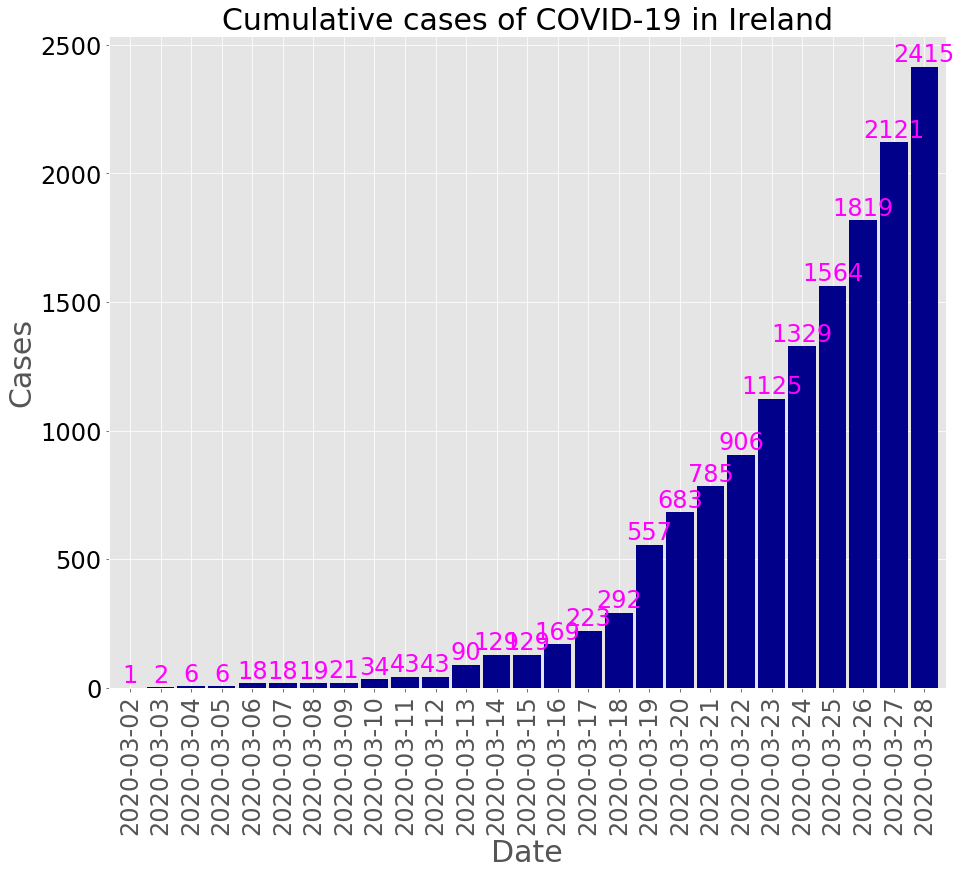

In [8]:
font_size = 30
plot_name = f'Cumulative cases of COVID-19 in {country}'
df_ref = df_ire[40:][:]
#ax = df_ref.plot(kind='scatter', x='Date', y='Cases', figsize=(10, 6), color='darkblue', marker='x', s=150)
ax = df_ref.plot(kind='bar', x='Date', y='Cases', figsize=(15, 12), color='darkblue', width = 0.9, legend=None)
ax.set_xticklabels(list(df_ref['Date']), rotation='vertical')
ax.tick_params(axis='both', which='major', labelsize=0.8*font_size)
ax.tick_params(axis='y', labelcolor='k')
ax.set_ylabel(df_ref.columns[1], fontsize=font_size)
ax.set_xlabel(df_ref.columns[0], fontsize=font_size)
ax.set_title(plot_name, fontsize=font_size)
for index, value in enumerate(df_ref.loc[:,'Cases']):
    ax.annotate(int(value), 
                xy = (index, value), 
                color='magenta', 
                alpha=1, 
                fontsize=0.8*font_size, 
                ha='center', 
                va='bottom',)
plt.gcf().savefig(plot_name+'.png') # https://stackoverflow.com/a/19555675

# 3. Model the cumulative number of cases<a id="2"></a>

[Model source](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

In [9]:
df_ire.head()

,Date,Cases,Day
0,2020-01-22,0,1.0
1,2020-01-23,0,2.0
2,2020-01-24,0,3.0
3,2020-01-25,0,4.0
4,2020-01-26,0,5.0


**Logistic (sigmoid) Model:** [Ref](https://en.wikipedia.org/wiki/Sigmoid_function)

In [10]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [11]:
df_model = df_ire.copy() # to include all days
x = list(df_model.iloc[:,2]) # x input for the model
y = list(df_model.iloc[:,1].astype(float)) # real data to which the model will be fit
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(logistic_model, x, y, p0=[3,50,2000], maxfev=10000) # fit the model to the data

Result of the fit:

In [12]:
a, b, c = popt
print('=====According to a logistic-based model=======')
print(f'Infection speed: a={round(a,2)}\nDay of maximum number of infections, b={round(b)}\nProjected total number of infections, c={round(c)}')

=====According to a logistic-based model=======
Infection speed: a=3.65
Day of maximum number of infections, b=65.0
Projected total number of infections, c=3861.0


**Find when the number of cases flattens out**

In [13]:
x = np.linspace(1,df_ire.shape[0],df_ire.shape[0])
y_model = logistic_model(x, a, b, c)
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
print(f'Day that the infections level out: {sol}.')

Day that the infections level out: 96.


Put the result in a dataframe

In [14]:
data = {'Day': x, 'Cases_model': y_model}
df_ire_model = pd.DataFrame(data)
df_ire_model

,Day,Cases_model
0,1.0,0.000086
1,2.0,0.000113
2,3.0,0.000148
3,4.0,0.000195
4,5.0,0.000256
...,...,...
62,63.0,1348.008851
63,64.0,1597.348582
64,65.0,1858.693437
65,66.0,2122.696943


**Get the number of new cases per day**

In [15]:
df_ire['New_Cases'] = np.linspace(0,0,df_ire.shape[0])
for i in range(0, len(df_ire['New_Cases'])-1):
    df_ire.loc[i+1,'New_Cases'] = df_ire.loc[i+1,'Cases'] - df_ire.loc[i, 'Cases']

**Put the model and 'real cases' in one dataframe**

In [16]:
df_ire = pd.concat([df_ire, df_ire_model['Cases_model']], axis=1)
df_ire.tail()

,Date,Cases,Day,New_Cases,Cases_model
62,2020-03-24,1329,63.0,204.0,1348.008851
63,2020-03-25,1564,64.0,235.0,1597.348582
64,2020-03-26,1819,65.0,255.0,1858.693437
65,2020-03-27,2121,66.0,302.0,2122.696943
66,2020-03-28,2415,67.0,294.0,2379.629223


**Plot the model and real cases together**

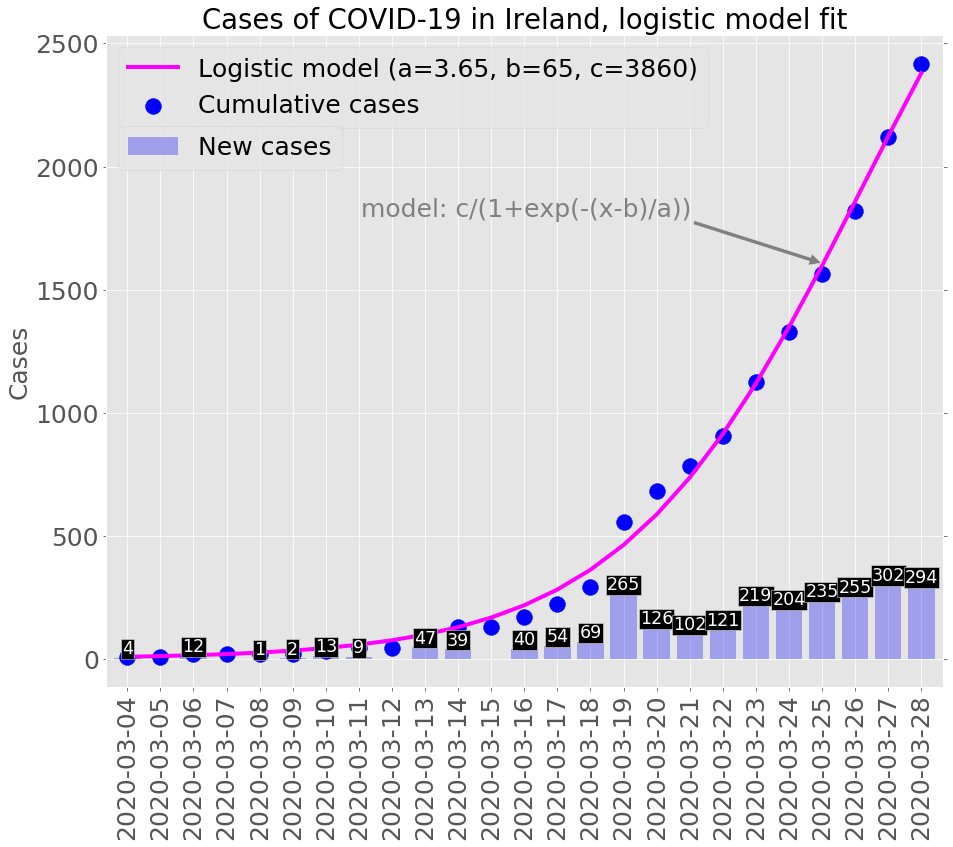

In [18]:
font_size = 25
dayfrom = 42
scale = 1
plot_name = f'Cases of COVID-19 in {country}, logistic model fit'
df_plot = df_ire.copy()[dayfrom:]
dayto = df_plot.shape[0]
#
ax1 = df_plot.plot(kind='scatter', x='Date', y='Cases', figsize=(15, 12), color='blue', marker='.', s=1000)
ax1 = df_plot.plot(kind='line', x='Date', y='Cases_model', figsize=(15, 12), color='magenta', linewidth=4, ax=ax1) #, marker='x', s=150)
ax1.set_title(plot_name, fontsize=1.1*font_size)
ax1.set_xticklabels(list(df_plot['Date']), rotation='vertical')
ax1.tick_params(axis='both', which='major', labelsize=1*font_size)
ax1.set_ylabel('Cases', fontsize=font_size)
ax1.set_xlabel('')
ax1.legend((f'Logistic model (a={round(a,2)}, b={int(b)}, c={int(c)})', 'Cumulative cases'), fontsize=1*font_size)
y2_lim = ax1.get_ylim()
#
ax2 = ax1.twinx()
df_plot.plot(kind='bar', x='Date', y='New_Cases', figsize=(15, 12), color='blue', alpha=0.3, width=0.8, ax=ax2, grid=False, legend=False)
ax2.tick_params(axis='both', which='major', labelsize=font_size)
ax2.set_ylim(scale*y2_lim[0], scale*y2_lim[1])
ax2.set_yticklabels('')
ax2.legend(['New cases',], fontsize=1*font_size, loc=2, bbox_to_anchor=(0, 0.88))
#
for index, value in enumerate(df_plot.loc[:,'New_Cases']):
    if value > 0:
        ax2.annotate(int(value), 
                xy = (index, value), 
                color='white', 
                alpha=1, 
                fontsize=0.7*font_size, 
                ha='center', 
                va='bottom',
                bbox=dict(fc='k', pad=1, alpha=1))
#https://matplotlib.org/tutorials/text/annotations.html
ax2.annotate("model: c/(1+exp(-(x-b)/a))", xy=(0.855, 0.65),  xycoords='axes fraction', 
            xytext=(0.7, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='grey', shrink=0.0),
            horizontalalignment='right', verticalalignment='top', fontsize=1*font_size, color='grey'
            )
#
plt.gcf().savefig(plot_name+'.png', bbox_inches="tight") # https://stackoverflow.com/a/19555675

**Plot the model and real cases together to the 'end day' (c in the figure)**

In [19]:
# create future dates
no_days = sol+5
dates = pd.date_range(start='22-1-2020', periods = no_days-1).date.astype(str).tolist()
dates = dates[df_ire.shape[0]:] # dates in the future to the end day 'sol'
# array for days to the 'end'
day = np.arange(int(df_plot.Day.max())+1, no_days)
# result for those days
new = logistic_model(day,a,b,c)
#check the lengths
print(len(day), len(new), len(dates))

33 33 33


Put those results in a dataframe

In [20]:
data = {'Date': dates, 'Cases': ['']*len(day), 'Day': day, 'New_Cases': ['']*len(day), 'Cases_model': new, }
df_plot2 = pd.DataFrame(data)
df_plot = pd.concat([df_plot, df_plot2], axis=0).reset_index()
df_plot.tail()

,index,Date,Cases,Day,New_Cases,Cases_model
53,28,2020-04-26,,96.0,,3859.934764
54,29,2020-04-27,,97.0,,3860.137452
55,30,2020-04-28,,98.0,,3860.291542
56,31,2020-04-29,,99.0,,3860.408684
57,32,2020-04-30,,100.0,,3860.497736


Plot it

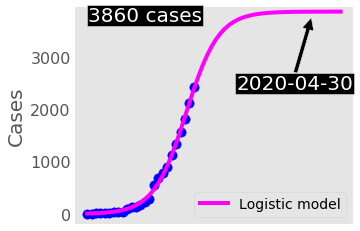

In [21]:
font_size = 20
scale = 1
plot_name = f'Cases of COVID-19 in {country} with logistic model to end'
ax1 = df_plot[:dayto].plot(kind='scatter', x='Date', y='Cases', figsize=(5, 4), color='blue', marker='.', s=350)
ax1 = df_plot.plot(kind='line', x='Date', y='Cases_model', figsize=(5, 4), color='magenta', linewidth=4, ax=ax1) #, marker='x', s=150)
ax1.set_xticklabels('')
ax1.tick_params(axis='both', which='major', labelsize=0.8*font_size, grid_alpha=0, length=0)
ax1.set_ylabel('Cases', fontsize=font_size)
ax1.set_xlabel('')
y1, y2 = ax1.get_ylim()
ax1.set_ylim((y1, c + 100))
ax1.legend(('Logistic model',), fontsize=0.7*font_size)
ax1.annotate(df_plot.Date.iloc[-1], xy=(0.85, 0.95),  xycoords='axes fraction', 
            xytext=(1, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='k', shrink=0.01),
            horizontalalignment='right', verticalalignment='bottom', fontsize=1*font_size, color='white',
             bbox=dict(fc='k', pad=1, alpha=1)
            )
ax1.annotate((str(int(c))+' cases'), xy=(0.85, 0.95),
            xycoords='axes fraction', 
            xytext=(0.05, 1), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=1*font_size, color='white',
             bbox=dict(fc='k', pad=1, alpha=1)
            )
plt.gcf().savefig(plot_name+'.png') # https://stackoverflow.com/a/19555675